In [79]:
import tensorflow as tf
from art.estimators.classification import KerasClassifier #No soporta TF 2
from art.attacks.evasion import FastGradientMethod
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()

In [80]:
vulnerable_model = tf.keras.models.load_model("modelo_victima_lab7_cat")

In [81]:
clasificador = KerasClassifier(
    model=vulnerable_model
)

<h1>Ataque de Evasión</h1>

In [82]:
#Ataque usando Gradiente Descendiente para generar imagenes adversariales
#Epsilon define que tan fuerte será el ataque:
#Debe haber un equilibrio entre la fuerza del ataque y la detección a simple vista que permita detectar que una imagen fue atacada

attack_fgsm = FastGradientMethod(
    estimator=clasificador, 
    eps=0.3
    )

In [83]:
# load images as numpy arrays from directory 'malimg_paper_dataset_imgs'
images = []
labels = []
resolutions = []
main_directory = './malimg_paper_dataset_imgs'
for subfolder in os.listdir(main_directory):
    subfolder_path = os.path.join(main_directory, subfolder)
    if os.path.isdir(subfolder_path):
        # Iterate over files in the subfolder
        for file_name in os.listdir(subfolder_path):
            # Check if the file has the extension .png
            if file_name.endswith('.png'):
                file_path = os.path.join(subfolder_path, file_name)
                
                # Load the image using PIL
                image = Image.open(file_path)
                
                # Convert the image to a NumPy array and add it to the list
                image_np = np.array(image)

                # si la resolucion no esta en la lista, agregarla
                if image_np.shape not in resolutions:
                    resolutions.append(image_np.shape)
                #if (image_np.shape == (410, 512) or image_np.shape == (409, 512)):
                #if (image_np.shape == (410, 512)):
                images.append(image_np)
                labels.append(subfolder)

# Convert the list of image arrays into a single NumPy array
images_np = np.array(images)

C:\Users\julio\AppData\Local\Temp\ipykernel_13192\3767540896.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images_np = np.array(images)


In [84]:
print(resolutions)

[(410, 512), (409, 512), (257, 64), (260, 64), (209, 64), (256, 64), (211, 64), (258, 64), (259, 64), (210, 64), (277, 64), (208, 64), (275, 64), (212, 64), (276, 64), (338, 64), (336, 64), (340, 64), (248, 256), (264, 256), (306, 256), (254, 256), (284, 256), (286, 256), (366, 256), (302, 256), (334, 256), (281, 256), (266, 256), (322, 256), (340, 256), (262, 256), (370, 256), (338, 256), (246, 256), (342, 256), (252, 256), (350, 256), (327, 256), (269, 256), (362, 256), (365, 256), (265, 256), (345, 256), (256, 256), (253, 256), (299, 256), (308, 256), (367, 256), (304, 256), (250, 256), (374, 256), (364, 256), (255, 256), (280, 256), (360, 256), (344, 256), (272, 256), (324, 256), (277, 256), (283, 256), (293, 256), (257, 256), (346, 256), (292, 256), (268, 256), (300, 256), (244, 256), (332, 256), (270, 256), (328, 256), (290, 256), (260, 256), (368, 256), (242, 256), (297, 256), (371, 256), (347, 256), (276, 256), (448, 128), (452, 128), (464, 128), (434, 128), (442, 128), (398, 1

In [85]:
print("type(image_dataset): ", type(images_np))
print("image_dataset shape: ", images_np.shape)
print("image_dataset example: ", images_np[0])
print("type(image_dataset example): ", type(images_np[0]))
print("image_dataset example shape: ", images_np[0].shape)

type(image_dataset):  <class 'numpy.ndarray'>
image_dataset shape:  (9339,)
image_dataset example:  [[ 77  90 144 ...  16   0   0]
 [  0 192   1 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [ 24  90 180 ... 141 232  19]
 [205 239  31 ...  44 168 210]
 [160 227 205 ...  70 168  12]]
type(image_dataset example):  <class 'numpy.ndarray'>
image_dataset example shape:  (410, 512)


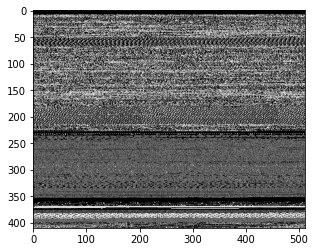

In [86]:
plt.imshow(images_np[0].astype(np.uint8), cmap='gray')

In [87]:
print("len labels: ", len(labels))

len labels:  9339


In [88]:
# reduce dataset, take only 100 random images
#indices = np.random.choice(len(labels), size=1000, replace=False)
#images_np = images_np[indices]
#labels = np.array(labels)[indices]

In [89]:
#print("labels shape: ", labels.shape)

In [90]:
# for each image in images_np, create an adversarial image
adversarial_images = []
input_images_3d = []
input_images = []
for image in images_np:
    # image to float32
    image = image.astype(np.float32)
    input_image = Image.fromarray(image.squeeze())
    resized_image = input_image.resize((256, 256))
    resized_array = np.array(resized_image)
    
    if len(resized_array.shape) == 2:  # If the array is grayscale, add an extra channel dimension
        resized_array = np.expand_dims(resized_array, axis=-1)
    elif resized_array.shape[2] > 3:  # If the array has more than 3 channels, keep only the first 3
        resized_array = resized_array[:, :, :3]

    input_array = np.expand_dims(resized_array, axis=0)  # Add a new dimension at the beginning
    input_array = np.repeat(input_array, 3, axis=-1)
    input_images.append(input_array)
    input_images_3d.append(input_array)

    #Generamos imagenes adversariales a partir de un dataset que queremos perturbar
    test_images_adv = attack_fgsm.generate(x=input_array)
    adversarial_images.append(test_images_adv[0])

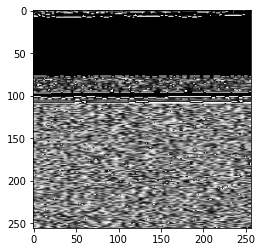

In [91]:
plt.imshow(input_images[123].astype(np.uint8)[0], cmap='gray')

In [92]:
len(adversarial_images)

9339

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


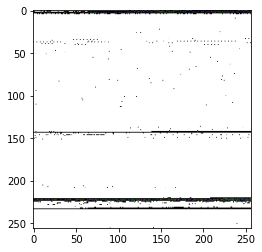

In [93]:
#Ejemplo de una perturbación
plt.imshow(X=adversarial_images[2])

In [94]:
# eliminar la segunda dimension de input_images
input_images = np.squeeze(input_images, axis=1)

In [95]:
# labels array to categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(labels)

In [96]:
input_images = np.array(input_images)
labels = np.array(labels)
print("input images shape: ", input_images.shape)
print("labels shape: ", labels.shape)

input images shape:  (9339, 256, 256, 3)
labels shape:  (9339,)


In [97]:
adversarial_images = np.array(adversarial_images)
print(adversarial_images.shape)

(9339, 256, 256, 3)


In [98]:
# Evaluating the model on clean images
score_clean = vulnerable_model.evaluate(
    x=input_images, 
    y=labels
    )

# Evaluating the model on adversarial images
score_adv = vulnerable_model.evaluate(
    x=adversarial_images, 
    y=labels
    )

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} " 
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} " 
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Clean test set loss: 0.69 vs adversarial set test loss: 0.67
Clean test set accuracy: 0.88 vs adversarial test set accuracy: 0.88


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

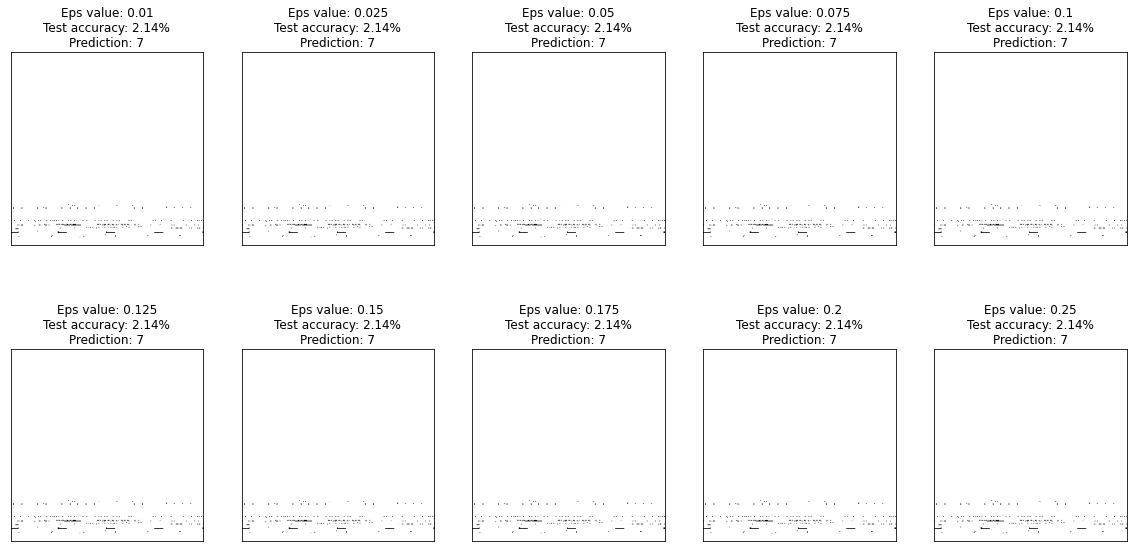

In [99]:
#Se prueba el accuracy para distintos valores de epsilon

# Setting the number of rows and columns for the figure
nrows, ncols = 2, 5

# Generating subplots
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20, 10)
    )

# Defining a range of eps values to try
eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]

# Defining a counting variable to traverse eps_to_try
counter = 0

# Iterating over rows and cols
for i in range(nrows):
    for j in range(ncols):    
        # Creating an attack object for the current value of eps    
        attack_fgsm = FastGradientMethod(
            estimator=clasificador, 
            eps=eps_to_try[counter]
            )
        
        # for each image in images_np, create an adversarial image
        adversarial_images = []
        for image in input_images_3d:

            #Generamos imagenes adversariales a partir de un dataset que queremos perturbar
            test_images_adv = attack_fgsm.generate(x=input_array)
            adversarial_images.append(test_images_adv[0])

        # Showing the first adversarial image
        axes[i, j].imshow(X=adversarial_images[0])

        # Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        adversarial_images = np.array(adversarial_images)

        # Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = clasificador._model.evaluate(
            x=adversarial_images, 
            y=labels
            )[1]

        # Getting prediction for the image that we displayed
        prediction = np.argmax(vulnerable_model.predict(
            x=np.expand_dims(a=adversarial_images[0], 
            axis=0)
            ))

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        # Incrementing counter
        counter += 1

# Showing the plot
plt.show()